In [1]:
import os
import numpy as np
from scipy.stats import norm
import math
os.environ["NUMBA_ENABLE_CUDASIM"] = "1"
import numba
from numba import jit, njit, vectorize, cuda, float32, int32, int16

## Exercise 1

Create a vectorized version of log and exp math function for 1D array A = [2, 5, 10, 3, 8]

Results should be: 
+ [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
+ [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]

In [2]:
@vectorize([float32(float32)], target='parallel', fastmath=True)
def exp1D(x):
    return np.exp(x)

@vectorize([float32(float32)], target='parallel', fastmath=True)
def log1D(x):
    return np.log(x)

A = np.array([2, 5, 10, 3, 8]).astype(np.float32) 
print('Vectorized version of exp:', exp1D(A))
print('Vectorized version of log:', log1D(A))

Vectorized version of exp: [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]
Vectorized version of log: [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]


## Exerice 2
Compute the value of a Gaussian probability density function at $x$ with $mean = 1$, $\sigma = 1$, lower and upper bound in $(-3, 3)$ and $size = 100000$

## Exercise 3

Create a "zero suppression" function. A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. 
Plot the data before and after the application of the zero_suppress function.

$thresold = 15$

Text(0.5, 1.0, 'Data with zero suppression')

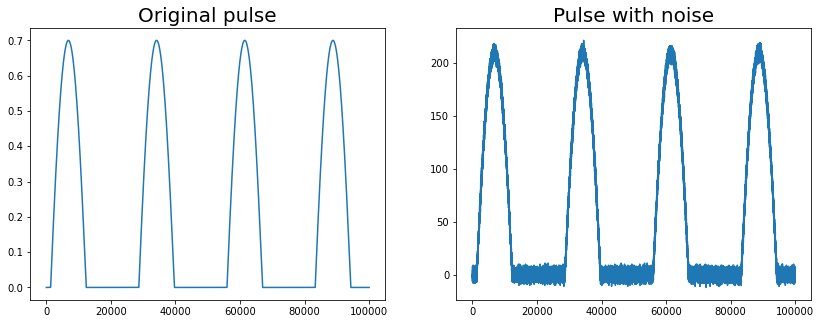

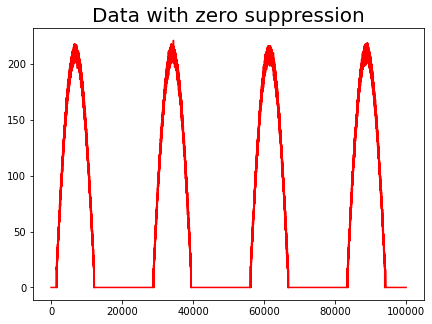

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt

thresold=15
def zero_supp(points):
    mask = [i for i in range(len(points)) if points[i] <= thresold]
    points[mask] = 0
    return points

n = 100000
noise = np.random.normal(size=n)*3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
data = ((pulses * 300) + noise).astype(np.int16)

fig, (a,b) = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
t = np.arange(0,n,1)
a.plot(t,pulses)
a.set_title('Original pulse', fontsize=20)
b.plot(t,data)
b.set_title('Pulse with noise', fontsize=20)

data2 = zero_supp(data)
plt.figure(figsize=(7, 5))
plt.plot(t,data2, color='r')
plt.title('Data with zero suppression', fontsize=20)

## Exercise 4

Calculate the Sigmoid kernel between the matrix X and Y defined as below. The Sigmoid kernel is defined as:

$k(x,y) = \tanh(\alpha x^T y + c) $

In [4]:
def sig_ker(arr):
    return np.tanh(1*(arr[0].T)*arr[1] + 1)

X = np.random.rand(3,3).astype(np.float32) 
Y = np.random.rand(3,3).astype(np.float32)

print(sig_ker([X,Y]))

[[0.7708312  0.884327   0.8506012 ]
 [0.848416   0.9108784  0.76225007]
 [0.86845285 0.89261955 0.7725277 ]]


## Exercise 5

Create a kernel function similar to the ```double_kernel``` see during the lecture and create a new function that takes a 3 dimensional matrix as input calculating the $cos$ for each element and then returns the result. The shape of the matrix must be $256X256X256$. The matrix can be randomly generated

In [6]:
@cuda.jit
def cos_3D(io_array):
    x, y, z = cuda.grid(3)
    if x < io_array.shape[0] and y < io_array.shape[1] and z < io_array.shape[2]:
        io_array[x][y][z] = np.cos(io_array[x][y][z])

data = np.random.random(size=(256,256,256))

# Configure the blocks
threadsperblock = (32, 4, 2)
blockspergrid_x = int(math.ceil(data.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(data.shape[1] / threadsperblock[1]))
blockspergrid_z = int(math.ceil(data.shape[2] / threadsperblock[2]))
blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)

cos_3D[blockspergrid, threadsperblock](data)
print(data)

[[[0.97652768 0.85438049 0.88164172 ... 0.92723125 0.83183904 0.74523264]
  [0.99193182 0.97656953 0.82349611 ... 0.61078332 0.72200519 0.56026851]
  [0.91067896 0.65551318 0.73145314 ... 0.96986083 0.77780314 0.76503551]
  ...
  [0.99278868 0.97151306 0.9327053  ... 0.7646898  0.99941307 0.73826398]
  [0.9064505  0.69153184 0.95334843 ... 0.99578652 0.74914972 0.81004258]
  [0.98430702 0.69557278 0.98519067 ... 0.60207411 0.91226347 0.94652125]]

 [[0.99984939 0.94042876 0.9292819  ... 0.82779762 0.5518211  0.74296768]
  [0.93056763 0.55166047 0.84550047 ... 0.55006559 0.94396863 0.81860122]
  [0.58858585 0.6787045  0.91966371 ... 0.90174125 0.8295636  0.98646087]
  ...
  [0.80449425 0.88757942 0.87391091 ... 0.60855405 0.99554895 0.93648319]
  [0.99970838 0.99950084 0.9991409  ... 0.56470788 0.70696744 0.66079061]
  [0.93409641 0.75956138 0.71286391 ... 0.61474757 0.86155915 0.57708799]]

 [[0.9925107  0.9946929  0.93182846 ... 0.78034271 0.85225905 0.67172359]
  [0.77788435 0.562351

## Exercise 6

Create a matrix multiplication kernel function, called ```matmul``` that takes as input two 2D matrices:
+ A of shape $24x12$
+ B of shape $12x22$
and that computes the multiplication and put the results into a third matrix C of shape $24x12$

A and B must be randomly generated and only int values are allowed.


In [5]:
from __future__ import division
from numba import cuda
import numpy
import math

# complete the code
@cuda.jit
def matmul(A, B, C):
    """Perform matrix multiplication of C = A * B
    """
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp

# Initialize the data arrays
#np.random.seed(313)
A = np.random.randint(0,10,size=(24,12))
B = np.random.randint(0,10,size=(12,24))
C = np.zeros((24,24))

# Configure the blocks
threadsperblock = (12,2)
blockspergrid_x = int(math.ceil(A.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(B.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

matmul[blockspergrid, threadsperblock](A,B,C)
print(C)

[[202. 199. 190. 278. 248. 236. 267. 252. 249. 203. 212. 212. 277. 196.
  154. 211. 232. 220. 204. 139. 188. 224. 265. 192.]
 [185. 196. 233. 234. 232. 196. 239. 268. 218. 243. 179. 269. 224. 252.
  160. 212. 188. 180. 169. 193. 217. 227. 207. 189.]
 [255. 250. 292. 296. 283. 243. 339. 303. 271. 319. 201. 284. 244. 288.
  113. 286. 275. 176. 199. 251. 277. 299. 242. 246.]
 [225. 258. 220. 271. 295. 252. 338. 300. 297. 273. 279. 313. 228. 266.
  184. 279. 305. 206. 201. 211. 245. 267. 219. 262.]
 [219. 250. 221. 277. 292. 247. 305. 258. 308. 278. 253. 309. 237. 274.
  160. 261. 296. 195. 205. 202. 235. 260. 202. 246.]
 [124. 162. 173. 206. 210. 163. 222. 180. 228. 229. 142. 211. 196. 176.
   97. 127. 177. 182. 129. 160. 177. 203. 167. 120.]
 [241. 227. 223. 277. 278. 221. 304. 331. 282. 251. 273. 325. 263. 279.
  236. 251. 282. 236. 232. 183. 218. 235. 256. 234.]
 [184. 283. 255. 294. 312. 289. 304. 263. 283. 284. 224. 294. 276. 273.
  145. 272. 219. 213. 158. 228. 275. 323. 222. 242.]
